# Task 1 : Set up colab gpu runtime environment

In [56]:
%%capture
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 7.31 MiB/s, done.
Resolving deltas: 100% (3/3), done.


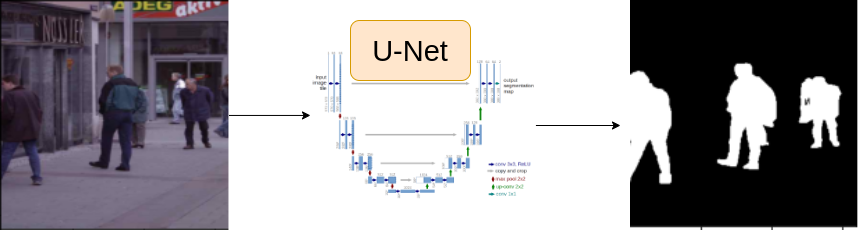

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [24]:
CSV_FILE = "/content/Human-Segmentation-Dataset-master/train.csv"
DATA_DIR = "/content/"

DEVICE = 'cuda'

EPOCS = 25
LR = 0.003
IMG_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [6]:
df = pd.read_csv(CSV_FILE)
df

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
...,...,...
285,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
286,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
287,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
288,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
row = df.iloc[4]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

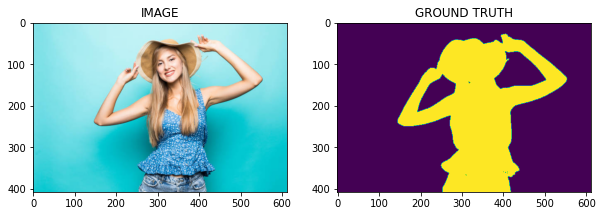

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
# ax2.imshow(mask,cmap = 'gray')
ax2.imshow(mask)

In [9]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [10]:
import albumentations as A

In [11]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
  ])

# Task 4 : Create Custom Dataset 

In [12]:
from torch.utils.data import Dataset

In [13]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #we have to add a channel with (h, w) which looks like (h, w, c)
    mask = np.expand_dims(mask, axis = -1)


    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

    #(h, w, c) -> (c, h, w)

    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask)/255.0)

    return image, mask


In [14]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())


In [15]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


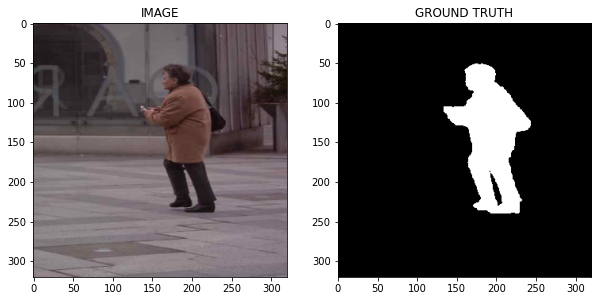

In [16]:
idx = 9

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [17]:
from torch.utils.data import DataLoader

In [18]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [19]:
print(f"total no. of batches in trainloader : {len(trainloader)}")
print(f"total no. of batches in validloader : {len(validloader)}")

total no. of batches in trainloader : 15
total no. of batches in validloader : 4


In [20]:
for image, mask in trainloader:
  break

print(f"One batch image shape :{image.shape}")
print(f"One batch mask shape :{mask.shape}")

One batch image shape :torch.Size([16, 3, 320, 320])
One batch mask shape :torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [21]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [22]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):
    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode = 'binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)

      return logits, loss1+loss2

    return logits

In [26]:
model = SegmentationModel()
model.to(DEVICE);  # ; to remove the output texts

# Task 7 : Create Train and Validation Function 

In [27]:
def train_fn(data_loader, model, optimizer):
  
  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)


In [28]:
def eval_fn(data_loader, model):
  
  model.eval()
  total_loss = 0.0

  with torch.no_grad():

    for images, masks in tqdm(data_loader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()

  return total_loss / len(data_loader)

# Task 8 : Train Model

In [29]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [31]:
best_valid_loss = np.Inf

for i in range(EPOCS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_Model.pt')
    print("Model Successfully saved!")

    best_valid_loss = valid_loss

  print(f"Epoch : {i+1} Train_loss : {train_loss}, Valid_loss : {valid_loss}")
  

100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


Model Successfully saved!
Epoch : 1 Train_loss : 0.8346191247304281, Valid_loss : 2.6501640379428864


100%|██████████| 4/4 [00:00<00:00,  5.00it/s]


Model Successfully saved!
Epoch : 2 Train_loss : 0.3860387444496155, Valid_loss : 1.116493597626686


100%|██████████| 4/4 [00:00<00:00,  5.02it/s]


Model Successfully saved!
Epoch : 3 Train_loss : 0.3120983213186264, Valid_loss : 0.23159964755177498


100%|██████████| 4/4 [00:00<00:00,  5.01it/s]


Epoch : 4 Train_loss : 0.26412642101446787, Valid_loss : 0.28065645694732666


100%|██████████| 4/4 [00:00<00:00,  4.96it/s]


Epoch : 5 Train_loss : 0.2722767551740011, Valid_loss : 0.25078338012099266


100%|██████████| 4/4 [00:00<00:00,  4.98it/s]


Epoch : 6 Train_loss : 0.21131948630015054, Valid_loss : 0.25491929426789284


100%|██████████| 4/4 [00:00<00:00,  4.85it/s]


Model Successfully saved!
Epoch : 7 Train_loss : 0.18167202174663544, Valid_loss : 0.21101899445056915


100%|██████████| 4/4 [00:00<00:00,  5.01it/s]


Model Successfully saved!
Epoch : 8 Train_loss : 0.17254009942213694, Valid_loss : 0.18884776532649994


100%|██████████| 4/4 [00:00<00:00,  4.96it/s]


Epoch : 9 Train_loss : 0.1547564814488093, Valid_loss : 0.22549954056739807


100%|██████████| 4/4 [00:00<00:00,  4.84it/s]


Epoch : 10 Train_loss : 0.16570765376091004, Valid_loss : 0.20484697818756104


100%|██████████| 4/4 [00:00<00:00,  5.00it/s]


Epoch : 11 Train_loss : 0.1399545858303706, Valid_loss : 0.23087146878242493


100%|██████████| 4/4 [00:00<00:00,  4.96it/s]


Epoch : 12 Train_loss : 0.14062334597110748, Valid_loss : 0.27395807951688766


100%|██████████| 4/4 [00:00<00:00,  5.00it/s]


Epoch : 13 Train_loss : 0.17169030706087748, Valid_loss : 0.22429867088794708


100%|██████████| 4/4 [00:00<00:00,  4.91it/s]


Epoch : 14 Train_loss : 0.14338856240113576, Valid_loss : 0.2066900134086609


100%|██████████| 4/4 [00:00<00:00,  4.98it/s]


Model Successfully saved!
Epoch : 15 Train_loss : 0.15239522606134415, Valid_loss : 0.1729435920715332


100%|██████████| 4/4 [00:00<00:00,  5.02it/s]


Epoch : 16 Train_loss : 0.15101900696754456, Valid_loss : 0.4269707277417183


100%|██████████| 4/4 [00:00<00:00,  4.90it/s]


Epoch : 17 Train_loss : 0.1871096635858218, Valid_loss : 0.30728162080049515


100%|██████████| 4/4 [00:00<00:00,  4.97it/s]


Epoch : 18 Train_loss : 0.16385164509216946, Valid_loss : 0.2400353793054819


100%|██████████| 4/4 [00:00<00:00,  4.88it/s]


Epoch : 19 Train_loss : 0.16446246802806855, Valid_loss : 0.30771031230688095


100%|██████████| 4/4 [00:00<00:00,  4.93it/s]


Epoch : 20 Train_loss : 0.1742982029914856, Valid_loss : 0.1913742646574974


100%|██████████| 4/4 [00:00<00:00,  5.00it/s]


Epoch : 21 Train_loss : 0.14705803294976552, Valid_loss : 0.2070222795009613


100%|██████████| 4/4 [00:00<00:00,  5.02it/s]


Epoch : 22 Train_loss : 0.15982787211736044, Valid_loss : 0.3105979934334755


100%|██████████| 4/4 [00:00<00:00,  4.82it/s]


Epoch : 23 Train_loss : 0.12629909366369246, Valid_loss : 0.17810432612895966


100%|██████████| 4/4 [00:00<00:00,  4.98it/s]


Epoch : 24 Train_loss : 0.1074220488468806, Valid_loss : 0.17571411840617657


100%|██████████| 4/4 [00:00<00:00,  5.02it/s]

Epoch : 25 Train_loss : 0.1082393412788709, Valid_loss : 0.17355460487306118


# Task 9 : Inference

In [38]:
idx = 12

model.load_state_dict(torch.load('/content/best_Model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(C, H, W) -> (1, C, H, W)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

In [54]:
path = '/content/istockphoto-1198252595-612x612.jpg'

image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image = cv2.resize(image, (320, 320))

image = np.transpose(image, (2, 0, 1)).astype(np.float32)

image = torch.Tensor(image) / 255.0

model.load_state_dict(torch.load('/content/best_Model.pt'))


logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(C, H, W) -> (1, C, H, W)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

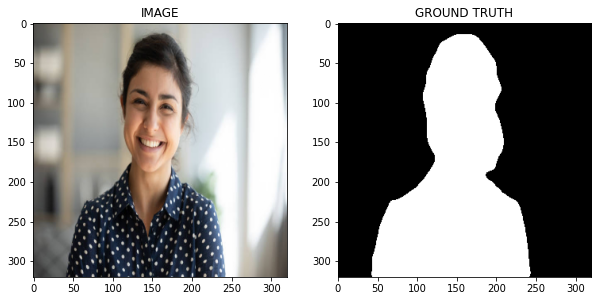

In [55]:
helper.show_image(image, pred_mask.detach().cpu().squeeze(0))